<a href="https://colab.research.google.com/github/gujjasaiganesh/Brain-Image-Analysis-For-Early-Detection-Of-Alzheimer-s/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import seaborn as sns
import pandas as pd
from tensorflow.keras import backend as K

# Paths
DATASET_DIR = "//content//drive//MyDrive//train"
MODEL_SAVE_DIR = "//content//drive//MyDrive//models"
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 50

# Data Preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Load the dataset and split it
data_flow = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

file_paths = data_flow.filepaths
labels = data_flow.classes

# Define class names
CLASSES = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']

# Split the dataset into train and test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    file_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

train_labels_str = [CLASSES[label] for label in train_labels]
test_labels_str = [CLASSES[label] for label in test_labels]

train_df = pd.DataFrame({"filename": train_paths, "class": train_labels_str})
test_df = pd.DataFrame({"filename": test_paths, "class": test_labels_str})

# Generators for training and testing
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 2044 images belonging to 4 classes.
Found 1635 validated image filenames belonging to 4 classes.
Found 409 validated image filenames belonging to 4 classes.


In [ ]:


# Model Building using Functional API for Grad-CAM compatibility
input_layer = Input(shape=(128, 128, 3))
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_layer)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
output_layer = Dense(len(CLASSES), activation='softmax')(x)

# Build the final model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train Model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy: {test_accuracy}")


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 947s 14s/step - accuracy: 0.6200 - loss: 0.8876 - val_accuracy: 0.2543 - val_loss: 1.5675
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.8159 - loss: 0.5213 - val_accuracy: 0.2469 - val_loss: 1.7484
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8992 - loss: 0.2716 - val_accuracy: 0.2518 - val_loss: 2.7366
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.8841 - loss: 0.3463 - val_accuracy: 0.2543 - val_loss: 1.6497
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9232 - loss: 0.2037 - val_accuracy: 0.2005 - val_loss: 2.3603
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9309 - loss: 0.2124 - val_accuracy: 0.2787 - val_loss: 1.7815
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.9675 - loss: 0.0955 - val_accuracy: 0.2078 - val_loss: 2.8917
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.9338 - loss: 0.1986 - val_accuracy: 0.4474 - va

In [ ]:
# Import necessary libraries
import pandas as pd

# Get true labels and predictions
y_true = test_generator.classes  # True class labels
class_indices = test_generator.class_indices  # Class labels mapping
class_labels = list(class_indices.keys())  # Convert to list of class names

# Predict probabilities
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)  # Predicted class indices

# Create a DataFrame for better visualization
results_df = pd.DataFrame({
    "True Label": [class_labels[i] for i in y_true],
    "Predicted Label": [class_labels[i] for i in y_pred_classes],
    "Confidence": [f"{np.max(prob) * 100:.2f}%" for prob in y_pred_probs]
})

# Display the DataFrame
pd.set_option('display.max_rows', None)  # Show all rows
print(results_df)

# Save predictions to a CSV file
results_df.to_csv("test_predictions.csv", index=False)
print("Predictions saved to 'test_predictions.csv'")


13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 932ms/step
               True Label       Predicted Label Confidence
0         Mild Impairment       Mild Impairment     87.38%
1    Very Mild Impairment  Very Mild Impairment     99.85%
2     Moderate Impairment   Moderate Impairment    100.00%
3           No Impairment         No Impairment     99.88%
4    Very Mild Impairment  Very Mild Impairment     99.64%
5           No Impairment         No Impairment    100.00%
6           No Impairment         No Impairment     99.99%
7           No Impairment         No Impairment    100.00%
8           No Impairment         No Impairment     99.98%
9    Very Mild Impairment  Very Mild Impairment     99.16%
10        Mild Impairment       Mild Impairment     99.98%
11   Very Mild Impairment         No Impairment     75.25%
12    Moderate Impairment   Moderate Impairment    100.00%
13          No Impairment         No Impairment    100.00%
14   Very Mild Impairment  Very Mild Impairment     99.80%
15   Very Mild

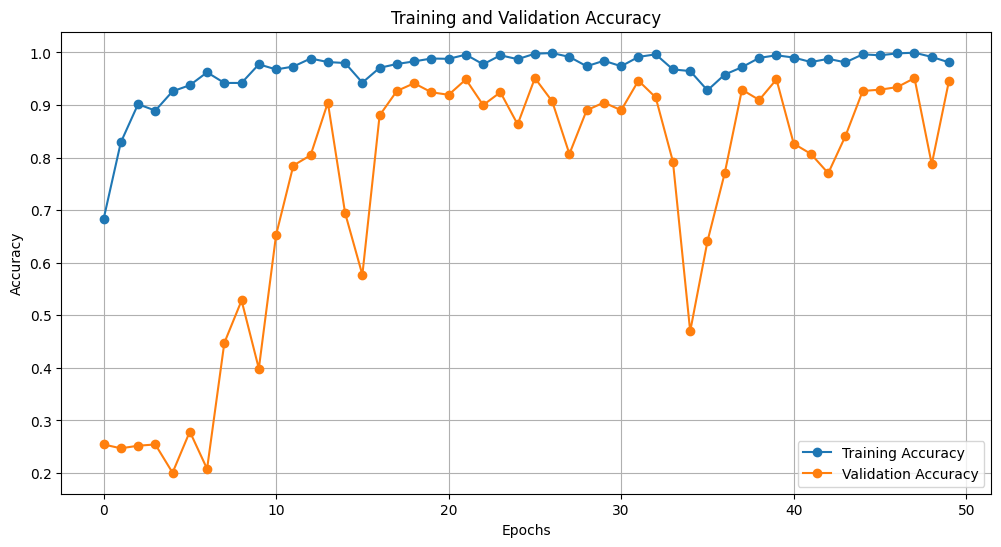

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Initialize time tracking for time series graph
start_time = time.time()
epoch_times = []

# Simulate epoch time recording for demonstration
for epoch in range(EPOCHS):
    epoch_times.append(time.time() - start_time)
    start_time = time.time()

# 1. Accuracy Graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()



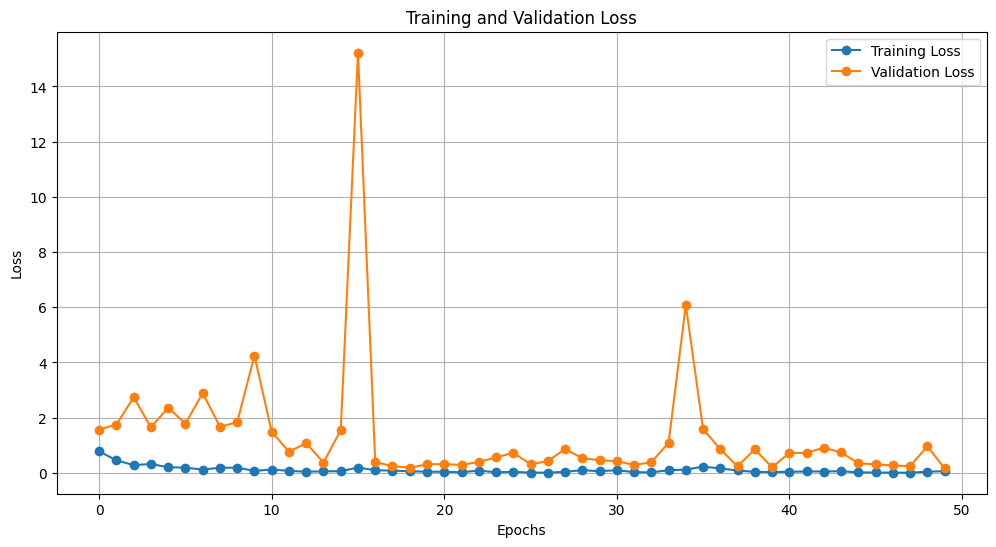

In [ ]:
# 2. Loss Graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



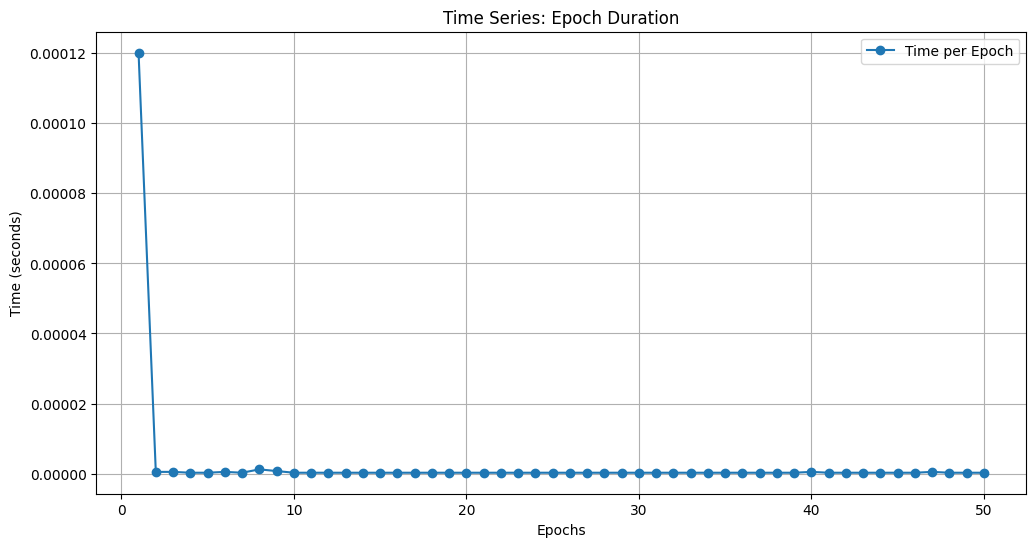

In [ ]:

# 3. Time Series Graph
plt.figure(figsize=(12, 6))
plt.plot(range(1, EPOCHS + 1), epoch_times, marker='o', label='Time per Epoch')
plt.title('Time Series: Epoch Duration')
plt.xlabel('Epochs')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:

# Confusion Matrix and Classification Report
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

balanced_accuracy = balanced_accuracy_score(y_true, y_pred_classes)
print(f"Balanced Accuracy: {balanced_accuracy}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step
Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.94      0.96      0.95       101
 Moderate Impairment       1.00      1.00      1.00       104
       No Impairment       0.92      0.94      0.93       103
Very Mild Impairment       0.93      0.88      0.90       101

            accuracy                           0.95       409
           macro avg       0.95      0.95      0.95       409
        weighted avg       0.95      0.95      0.95       409

Balanced Accuracy: 0.9458329328078439


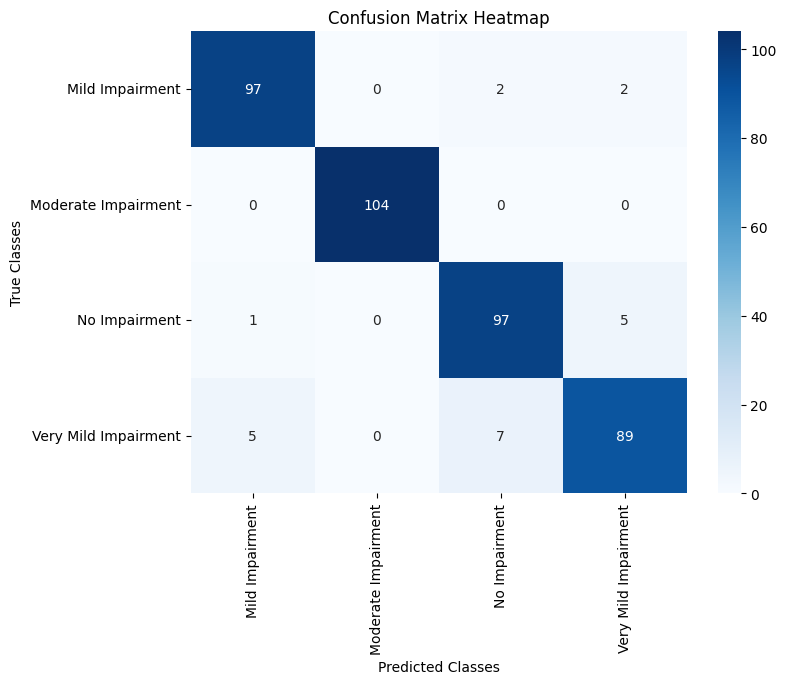

Model saved at: //content//drive//MyDrive//models/efficientnetb3_classifier.h5


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=CLASSES,
    yticklabels=CLASSES
)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Save Model
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
model.save(os.path.join(MODEL_SAVE_DIR, "efficientnetb3_classifier.h5"))
print(f"Model saved at: {MODEL_SAVE_DIR}/efficientnetb3_classifier.h5")



In [ ]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import numpy as np
import cv2
def preprocess_image(image_path, image_size=(128, 128)):
    """Preprocesses a single image for Grad-CAM visualization."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found at {image_path}")

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, image_size)  # Resize to expected shape (128, 128)
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    return tf.convert_to_tensor(image)
def create_custom_colormap():
    """Create a custom blue-to-yellow colormap compatible with OpenCV."""
    colors = [(0, 0, 1), (0.5, 0.5, 1), (1, 1, 0)]  # Blue to Yellow
    custom_colormap = LinearSegmentedColormap.from_list("blue_yellow", colors, N=256)

    # Convert to OpenCV-compatible format
    colormap_array = (custom_colormap(np.linspace(0, 1, 256))[:, :3] * 255).astype(np.uint8)
    return colormap_array

def visualize_grad_cam_no_red(image_path, model, layer_name="top_conv", image_size=(128, 128)):
    """Generates Grad-CAM visualization with only blue and yellow for 'No Impairment' predictions."""
    # Preprocess image
    image = preprocess_image(image_path, image_size)

    # Grad-CAM model setup
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Weight each channel by the corresponding gradient
    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1).numpy()

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap = cv2.resize(heatmap, (image_size[1], image_size[0]))
    heatmap = heatmap / heatmap.max() if heatmap.max() != 0 else heatmap

    # Original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, (image_size[1], image_size[0]))

    # Custom colormap for "No Impairment"
    predicted_label = CLASSES[predicted_class]
    if predicted_label == "No Impairment":
        custom_colormap = create_custom_colormap()

        # Apply custom colormap manually
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = np.zeros_like(original_image)
        for i in range(3):  # Apply each color channel from the colormap
            heatmap_color[:, :, i] = cv2.LUT(heatmap, custom_colormap[:, i])
    else:
        # Default colormap for other classes
        heatmap = np.uint8(255 * heatmap)
        heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Overlay heatmap
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

    # Plot comparison
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.axis('off')
    plt.title("Original Image")

    # Grad-CAM Image
    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f"Grad-CAM: {predicted_label}")

    plt.tight_layout()
    plt.show()

    # Analysis based on class
    print(f"Prediction: {predicted_label}")
    if predicted_label == "No Impairment":
        print("Heatmap excludes red areas, showing blue and yellow only.")
    elif predicted_label == "Moderate Impairment":
        print("Significant red areas indicate potential moderate impairment.")
    elif predicted_label == "Mild Impairment":
        print("Localized red areas suggest specific regions of mild impairment.")
    elif predicted_label == "Very Mild Impairment":
        print("Mild activation (yellow/orange) indicates very mild impairment.")

# Example Usage
example_image_path = "/content/drive/MyDrive/train/Moderate Impairment/ModerateImpairment (286).jpg"  # Replace with your image path
visualize_grad_cam_no_red(example_image_path, model, layer_name="top_conv")




NameError: name 'model' is not defined

Model loaded from /content/drive/MyDrive/models/efficientnetb3_classifier.h5
Found 2044 images belonging to 4 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


64/64 ━━━━━━━━━━━━━━━━━━━━ 705s 11s/step - accuracy: 0.9890 - loss: 0.0225
Test Accuracy: 0.9872798323631287
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 235ms/step
Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.99      0.99       505
 Moderate Impairment       1.00      1.00      1.00       522
       No Impairment       0.97      0.99      0.98       513
Very Mild Impairment       0.99      0.97      0.98       504

            accuracy                           0.99      2044
           macro avg       0.99      0.99      0.99      2044
        weighted avg       0.99      0.99      0.99      2044

Balanced Accuracy: 0.9871612819176655


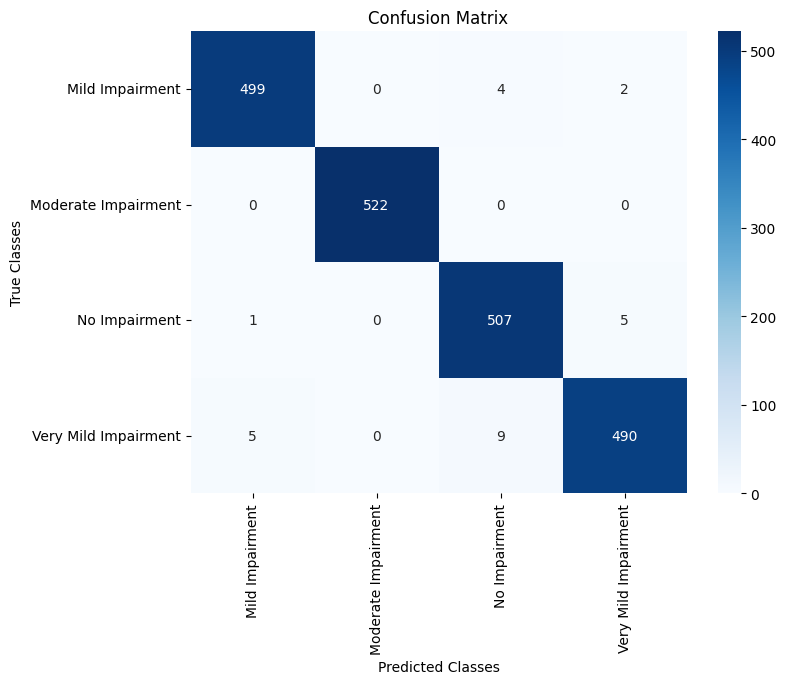

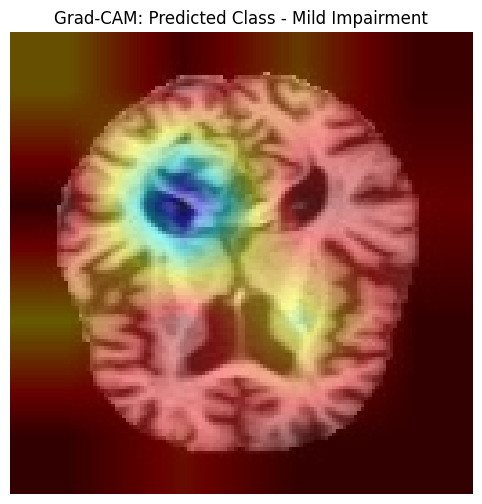

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Paths
MODEL_PATH = "/content/drive/MyDrive/models/efficientnetb3_classifier.h5"  # Update this path
DATASET_DIR = "/content/drive/MyDrive/train"  # Update this path
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
CLASSES = ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']

# Load the pretrained model
model = load_model(MODEL_PATH)
print(f"Model loaded from {MODEL_PATH}")

# Data Preprocessing
datagen = ImageDataGenerator(rescale=1.0 / 255.0)

data_flow = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(data_flow)
print(f"Test Accuracy: {test_accuracy}")

# Generate Predictions and Classification Report
y_true = data_flow.classes
y_pred_probs = model.predict(data_flow)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=CLASSES))

balanced_accuracy = balanced_accuracy_score(y_true, y_pred_classes)
print(f"Balanced Accuracy: {balanced_accuracy}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

# Grad-CAM Visualization
def preprocess_image(image_path, image_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img = img.astype('float32') / 255.0
    return np.expand_dims(img, axis=0)

def visualize_grad_cam(image_path, model, layer_name="top_conv", image_size=(128, 128)):
    image = preprocess_image(image_path, image_size)

    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(image)
        predicted_class = tf.argmax(predictions[0])
        loss = predictions[:, predicted_class]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    heatmap = tf.reduce_mean(conv_output * pooled_grads, axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = cv2.resize(heatmap, image_size)
    heatmap = heatmap / heatmap.max() if heatmap.max() != 0 else heatmap

    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.resize(original_image, image_size)

    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(original_image, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(f"Grad-CAM: Predicted Class - {CLASSES[predicted_class]}")
    plt.show()

# Example Usage of Grad-CAM
example_image_path = "/content/drive/MyDrive/patient/MildImpairment (242).jpg"  # Update this path
visualize_grad_cam(example_image_path, model)


Colab notebooks allow you to combine **executable code** and **rich text** in a single document, along with **images**, **HTML**, **LaTeX** and more. When you create your own Colab notebooks, they are stored in your Google Drive account. You can easily share your Colab notebooks with co-workers or friends, allowing them to comment on your notebooks or even edit them. To learn more, see [Overview of Colab](/notebooks/basic_features_overview.ipynb). To create a new Colab notebook you can use the File menu above, or use the following link: [create a new Colab notebook](http://colab.research.google.com#create=true).

Colab notebooks are Jupyter notebooks that are hosted by Colab. To learn more about the Jupyter project, see [jupyter.org](https://www.jupyter.org).

<div class="markdown-google-sans">

## Data science
</div>

With Colab you can harness the full power of popular Python libraries to analyze and visualize data. The code cell below uses **numpy** to generate some random data, and uses **matplotlib** to visualize it. To edit the code, just click the cell and start editing.

You can import your own data into Colab notebooks from your Google Drive account, including from spreadsheets, as well as from Github and many other sources. To learn more about importing data, and how Colab can be used for data science, see the links below under [Working with Data](#working-with-data).

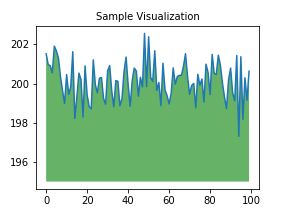

In [ ]:
import numpy as np
import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64

ys = 200 + np.random.randn(100)
x = [x for x in range(len(ys))]

fig = plt.figure(figsize=(4, 3), facecolor='w')
plt.plot(x, ys, '-')
plt.fill_between(x, ys, 195, where=(ys > 195), facecolor='g', alpha=0.6)
plt.title("Sample Visualization", fontsize=10)

data = io.BytesIO()
plt.savefig(data)
image = F"data:image/png;base64,{base64.b64encode(data.getvalue()).decode()}"
alt = "Sample Visualization"
display.display(display.Markdown(F"""![{alt}]({image})"""))
plt.close(fig)

Colab notebooks execute code on Google's cloud servers, meaning you can leverage the power of Google hardware, including [GPUs and TPUs](#using-accelerated-hardware), regardless of the power of your machine. All you need is a browser.

For example, if you find yourself waiting for **pandas** code to finish running and want to go faster, you can switch to a GPU Runtime and use libraries like [RAPIDS cuDF](https://rapids.ai/cudf-pandas) that provide zero-code-change acceleration.

To learn more about accelerating pandas on Colab, see the [10 minute guide](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_colab_demo.ipynb) or
 [US stock market data analysis demo](https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/cudf_pandas_stocks_demo.ipynb).

<div class="markdown-google-sans">

## Machine learning
</div>

With Colab you can import an image dataset, train an image classifier on it, and evaluate the model, all in just [a few lines of code](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/quickstart/beginner.ipynb).

Colab is used extensively in the machine learning community with applications including:
- Getting started with TensorFlow
- Developing and training neural networks
- Experimenting with TPUs
- Disseminating AI research
- Creating tutorials

To see sample Colab notebooks that demonstrate machine learning applications, see the [machine learning examples](#machine-learning-examples) below.

<div class="markdown-google-sans">

## More Resources

### Working with Notebooks in Colab

</div>

- [Overview of Colab](/notebooks/basic_features_overview.ipynb)
- [Guide to Markdown](/notebooks/markdown_guide.ipynb)
- [Importing libraries and installing dependencies](/notebooks/snippets/importing_libraries.ipynb)
- [Saving and loading notebooks in GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/main/notebooks/colab-github-demo.ipynb)
- [Interactive forms](/notebooks/forms.ipynb)
- [Interactive widgets](/notebooks/widgets.ipynb)

<div class="markdown-google-sans">

<a name="working-with-data"></a>
### Working with Data
</div>

- [Loading data: Drive, Sheets, and Google Cloud Storage](/notebooks/io.ipynb)
- [Charts: visualizing data](/notebooks/charts.ipynb)
- [Getting started with BigQuery](/notebooks/bigquery.ipynb)

<div class="markdown-google-sans">

### Machine Learning Crash Course

<div>

These are a few of the notebooks from Google's online Machine Learning course. See the [full course website](https://developers.google.com/machine-learning/crash-course/) for more.
- [Intro to Pandas DataFrame](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/pandas_dataframe_ultraquick_tutorial.ipynb)
- [Intro to RAPIDS cuDF to accelerate pandas](https://nvda.ws/rapids-cudf)
- [Linear regression with tf.keras using synthetic data](https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/linear_regression_with_synthetic_data.ipynb)

<div class="markdown-google-sans">

<a name="using-accelerated-hardware"></a>
### Using Accelerated Hardware
</div>

- [TensorFlow with GPUs](/notebooks/gpu.ipynb)
- [TensorFlow with TPUs](/notebooks/tpu.ipynb)

<div class="markdown-google-sans">

<a name="machine-learning-examples"></a>

### Featured examples

</div>

- [Retraining an Image Classifier](https://tensorflow.org/hub/tutorials/tf2_image_retraining): Build a Keras model on top of a pre-trained image classifier to distinguish flowers.
- [Text Classification](https://tensorflow.org/hub/tutorials/tf2_text_classification): Classify IMDB movie reviews as either *positive* or *negative*.
- [Style Transfer](https://tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization): Use deep learning to transfer style between images.
- [Multilingual Universal Sentence Encoder Q&A](https://tensorflow.org/hub/tutorials/retrieval_with_tf_hub_universal_encoder_qa): Use a machine learning model to answer questions from the SQuAD dataset.
- [Video Interpolation](https://tensorflow.org/hub/tutorials/tweening_conv3d): Predict what happened in a video between the first and the last frame.
